## Utils

In [670]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px
from IPython.display import display

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if column has any non-null values before checking type
            non_null_values = df[col].dropna()
            if len(non_null_values) > 0 and isinstance(non_null_values.iloc[0], Decimal):
                df[col] = df[col].astype(float)

    return df

In [671]:
def prepare_geo_map_data(df, metric):
    # Load CBSA polygons (MSA+µSA) from local file
    cbsa = gpd.read_file("./tl_2024_us_cbsa/tl_2024_us_cbsa.shp")
    cbsa['CBSAFP'] = cbsa['CBSAFP'].astype(str).str.zfill(5)

    # Keep only MSAs and mainland
    cbsa_ll = cbsa.to_crs(4326)
    rep_pts = cbsa_ll.geometry.representative_point()
    mainland_mask = rep_pts.x.between(-125, -66) & rep_pts.y.between(24, 50)
    cbsa_mainland = cbsa.loc[mainland_mask].copy()
    cbsa_mainland = cbsa_mainland.to_crs(5070)
    cbsa_mainland["geometry"] = cbsa_mainland.geometry.simplify(
        tolerance=1000, preserve_topology=True
    )

    merged = cbsa_mainland.merge(
        df[['cbsa', metric]],
        left_on="CBSAFP",
        right_on="cbsa",
        how="left"
    )

    # Fill missing values so map renders
    merged[metric] = merged[metric].fillna(0)
    epsilon = 1e-6
    merged[metric] = np.where(merged[metric] > 0, merged[metric], epsilon)

    return merged

In [672]:
def plot_geo_map_matplotlib(df, metric, title, figsize=(10, 5), legend_position="top_right", colormap="YlGnBu", colormap_start=0, colormap_end=1):
    """
    Create a choropleth map using matplotlib with ZERO whitespace,
    and a small horizontal colorbar inside the map.
    
    Parameters:
    df: GeoDataFrame with geometry and the metric column
    metric: string, name of the column to visualize  
    title: string, title for the colorbar
    figsize: tuple, figure size in inches (width, height)
    legend_position: 'bottom_left' or 'top_right'
    
    Returns:
    matplotlib figure with no whitespace
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    from matplotlib.colors import Normalize, ListedColormap
    import contextily as ctx

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    # Colormap
    base_cmap = cm.get_cmap(colormap)
    colors = [base_cmap(i) for i in np.linspace(colormap_start, colormap_end, 256)]
    dark_ylgnbu = ListedColormap(colors)

    # Normalize
    norm = Normalize(vmin=df[metric].min(), vmax=df[metric].max())

    # Plot data
    df.plot(
        column=metric,
        cmap=dark_ylgnbu,
        norm=norm,
        ax=ax,
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgray", "alpha": 0.5},
    )

    # Optional basemap
    try:
        df_web_mercator = df.to_crs(epsg=3857)
        ctx.add_basemap(ax, crs=df_web_mercator.crs, source=ctx.providers.CartoDB.Positron, alpha=0.5)
    except:
        pass

    ax.set_xlim(df.total_bounds[0], df.total_bounds[2])
    ax.set_ylim(df.total_bounds[1], df.total_bounds[3])

    # --- Add horizontal colorbar INSIDE map ---
    if legend_position == "bottom_left":
        cbar_ax = fig.add_axes([0.05, 0.05, 0.25, 0.025])  # bottom left
    elif legend_position == "top_right":
        cbar_ax = fig.add_axes([0.63, 0.98, 0.25, 0.015])  # top right
    else:
        raise ValueError("legend_position must be 'bottom_left' or 'top_right'")

    sm = plt.cm.ScalarMappable(cmap=dark_ylgnbu, norm=norm)
    sm.set_array([])
    # cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", ticks=np.linspace(df[metric].min(), df[metric].max(), 5))
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    import matplotlib.ticker as mticker
        # Use MaxNLocator for "nice" rounded ticks (in percent units)
    cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))  # up to 6 ticks

    # Format ticks as whole percentages (no decimals)
    cbar.ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))

    # Style the colorbar
    # cbar.set_label(title, fontsize=7, labelpad=2)
    cbar.ax.tick_params(labelsize=6)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.patch.set_facecolor("white")
    cbar.ax.patch.set_alpha(0.8)

    plt.margins(0, 0)

    return fig


## 0. Data Preparation

U.S. Population

In [673]:
df_us_pop = pd.read_csv('df_us_population_310_2024.csv')
df_us_pop['cbsa'] = df_us_pop['cbsa'].astype(str).str.zfill(5)

Submarket to MSA Mapping: 
We build the mapping between Large Submarket (>=100K lifetime deliveries) and MSAs. This maps 90% of the applicants. All internal data is anchored on Submarket and joined on MSAs for analysis.

In [674]:
df_mapping_raw = pd.read_csv('sm_to_msa_mapping_results.csv')
df_mapping_raw.columns = df_mapping_raw.columns.str.lower()
df_mapping = df_mapping_raw.copy()
df_mapping = df_mapping_raw[~df_mapping_raw['msa_title'].isna()].reset_index(drop=True)
df_mapping['cbsa_code'] = df_mapping['cbsa_code'].astype(str).str[:5]
df_mapping['cbsa'] = df_mapping['cbsa_code']
df_mapping['msa'] = df_mapping['msa_title']

Monthly Applicants and Lifetime Applicants by Subamrket (2019-01-01 till 2025-08-31)

In [675]:
df_apps = load_query('q1_lifetime_apps.sql')
df_apps['applied_month'] = pd.to_datetime(df_apps['applied_month'])

2025-09-07 23:15:36,181 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-07 23:15:36,182 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-07 23:15:36,531 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-07 23:15:36,531 - utils.snowflake_connection - INFO - Executing query (pandas)


Monthy Avg WAD by Submarket (2019-01-01 till 2025-08-31)

In [676]:
df_wad = load_query('q2_active_wad.sql')
df_wad['active_month'] = pd.to_datetime(df_wad['active_month'])

2025-09-07 23:15:44,733 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-07 23:15:44,733 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-07 23:15:44,958 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-07 23:15:44,959 - utils.snowflake_connection - INFO - Executing query (pandas)


Monthly New Dx and Lifetime New Dx by Submarket (2019-01-01 till 2025-08-01)

In [677]:
df_new_dx = load_query('q3_lifetime_new_dx.sql')
df_new_dx['first_dash_month'] = pd.to_datetime(df_new_dx['first_dash_month'])

2025-09-07 23:15:46,080 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-07 23:15:46,081 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-07 23:15:46,302 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-07 23:15:46,303 - utils.snowflake_connection - INFO - Executing query (pandas)


## 1. Market Saturation Current Snapshot

### (1) Lifetime Applicants as share of MSA Population

Group Applicants by MSAs

In [678]:
df_apps_msa = df_apps.merge(df_mapping[['submarket_id','msa','cbsa']], left_on='submarket_id', right_on='submarket_id', how='left')
df_apps_msa['msa_mapped'] = np.where(df_apps_msa['msa'].isna(), 'N', 'Y')

df_apps_msa = df_apps_msa.groupby(['applied_month','cbsa','msa','msa_mapped']).agg(
    {'apps_18_to_19': 'sum'
     , 'apps_18_to_24': 'sum'
     , 'apps_25_to_44': 'sum'
     , 'apps_45_to_64': 'sum'
     , 'apps_65_above': 'sum'
     , 'apps_18plus': 'sum'
     , 'apps_18_to_19_cumsum': 'sum'
     , 'apps_18_to_24_cumsum': 'sum'
     , 'apps_25_to_44_cumsum': 'sum'
     , 'apps_45_to_64_cumsum': 'sum'
     , 'apps_65_above_cumsum': 'sum'
     , 'apps_18plus_cumsum': 'sum'
     , 'submarket_id': 'count'
    }
    ).reset_index()

df_apps_msa = df_apps_msa.merge(df_us_pop, left_on='cbsa', right_on='cbsa', how='left')
df_apps_msa['population_mapped'] = np.where(df_apps_msa['name'].isna(), 'N', 'Y')

Take a snapshot at Aug'25

In [679]:
df_apps_msa_aug_25 = df_apps_msa[df_apps_msa['applied_month'] == '2025-08-01']
df_apps_msa_aug_25 = df_apps_msa_aug_25[df_apps_msa_aug_25['population_mapped'] == 'Y'].reset_index(drop=True) # 3 MSA not mapped, 4k apps monthly. 

# calculate share of population
df_apps_msa_aug_25['lifetime_apps_18plus_share_of_population'] = (df_apps_msa_aug_25['apps_18plus_cumsum'] / df_apps_msa_aug_25['age18plus_tot']).clip(upper=1)
df_apps_msa_aug_25['lifetime_apps_18to24_share_of_population'] = (df_apps_msa_aug_25['apps_18_to_24_cumsum'] / df_apps_msa_aug_25['age1824_tot']).clip(upper=1)

# keep relevant columns only
df_apps_msa_aug_25_share = df_apps_msa_aug_25[['cbsa', 'msa', 'apps_18plus', 'apps_18plus_cumsum', 'age18plus_tot', 'apps_18_to_24', 'apps_18_to_24_cumsum', 'age1824_tot', 'lifetime_apps_18plus_share_of_population', 'lifetime_apps_18to24_share_of_population']]
df_apps_msa_aug_25_share.sort_values(by='lifetime_apps_18to24_share_of_population', ascending=False).head(10)

,cbsa,msa,apps_18plus,apps_18plus_cumsum,age18plus_tot,apps_18_to_24,apps_18_to_24_cumsum,age1824_tot,lifetime_apps_18plus_share_of_population,lifetime_apps_18to24_share_of_population
664,43640,"Slidell-Mandeville-Covington, LA",2754,262255.0,213503.0,545,35378.0,21724.0,1.000000,1.000000
671,43980,"Spencer, IA",91,6662.0,12817.0,16,1350.0,1246.0,0.519778,1.000000
83,14010,"Bloomington, IL",1873,159200.0,136470.0,425,24044.0,29513.0,1.000000,0.814692
441,32340,"Maryville, MO",249,19623.0,17005.0,42,3063.0,4751.0,1.000000,0.644706
653,43180,"Shelbyville, TN",278,18837.0,40661.0,47,2913.0,4928.0,0.463269,0.591112
715,46460,"Union City, TN",86,5628.0,23711.0,16,1272.0,2305.0,0.237358,0.551844
436,32060,"Marion-Herrin, IL",229,15975.0,53310.0,20,2472.0,4700.0,0.299662,0.525957
117,15700,"Cambridge, MD",115,8631.0,26332.0,23,1186.0,2255.0,0.327776,0.525942
207,20500,"Durham-Chapel Hill, NC",3034,247488.0,501906.0,554,37883.0,73582.0,0.493096,0.514841
497,34820,"Myrtle Beach-Conway-North Myrtle Beach, SC",1512,108160.0,345706.0,290,16340.0,32799.0,0.312867,0.498186


In [680]:
df_apps_msa_aug_25_share.sort_values(by='lifetime_apps_18plus_share_of_population', ascending=False).head(20)

,cbsa,msa,apps_18plus,apps_18plus_cumsum,age18plus_tot,apps_18_to_24,apps_18_to_24_cumsum,age1824_tot,lifetime_apps_18plus_share_of_population,lifetime_apps_18to24_share_of_population
441,32340,"Maryville, MO",249,19623.0,17005.0,42,3063.0,4751.0,1.000000,0.644706
83,14010,"Bloomington, IL",1873,159200.0,136470.0,425,24044.0,29513.0,1.000000,0.814692
664,43640,"Slidell-Mandeville-Covington, LA",2754,262255.0,213503.0,545,35378.0,21724.0,1.000000,1.000000
671,43980,"Spencer, IA",91,6662.0,12817.0,16,1350.0,1246.0,0.519778,1.000000
207,20500,"Durham-Chapel Hill, NC",3034,247488.0,501906.0,554,37883.0,73582.0,0.493096,0.514841
635,42220,"Santa Rosa-Petaluma, CA",1722,189596.0,395970.0,0,11414.0,38498.0,0.478814,0.296483
653,43180,"Shelbyville, TN",278,18837.0,40661.0,47,2913.0,4928.0,0.463269,0.591112
733,47580,"Warner Robins, GA",890,61930.0,154022.0,122,7117.0,19246.0,0.402085,0.369791
541,37460,"Panama City-Panama City Beach, FL",966,68610.0,178509.0,162,7704.0,17792.0,0.384350,0.433004
306,25540,"Hartford-West Hartford-East Hartford, CT",3897,353772.0,944590.0,787,51520.0,117551.0,0.374524,0.438278


In [681]:
df_apps_msa_aug_25_share['apps_18plus_cumsum'].sum() / df_apps_msa_aug_25_share['age18plus_tot'].sum()

0.17067869829478796

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/3821216280.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/2281018365.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



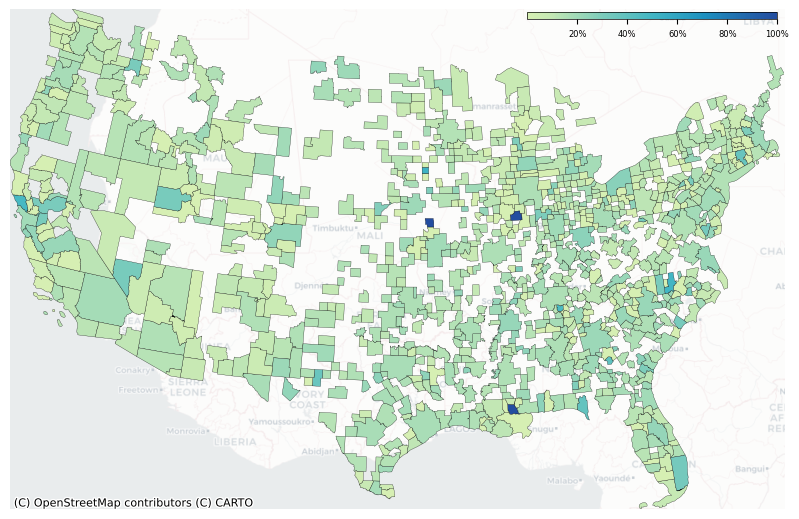

In [707]:
df = df_apps_msa_aug_25_share.copy()
metric = 'lifetime_apps_18plus_share_of_population'

merged = prepare_geo_map_data(df, metric)

fig = plot_geo_map_matplotlib(
    df=merged, 
    metric="lifetime_apps_18plus_share_of_population", 
    title="Lifetime Applicants Share (%) of 18+ Population",
    figsize=(10, 5),
    legend_position="top_right",
    colormap="YlGnBu", 
    colormap_start=0.2, 
    colormap_end=0.8
)

# Display it
fig.show()

# Or save it with no whitespace
fig.savefig('map.png', dpi=150, bbox_inches='tight', pad_inches=0)

### (2) WAD as a share of MSA Population

In [683]:
df_wad_msa = df_wad.merge(df_mapping[['submarket_id','msa','cbsa']], left_on='submarket_id', right_on='submarket_id', how='left')
df_wad_msa['msa_mapped'] = np.where(df_wad_msa['msa'].isna(), 'N', 'Y')

df_wad_msa = df_wad_msa.groupby(['active_month','cbsa','msa','msa_mapped']).agg(
    {'wad_18_to_19': 'sum'
     , 'wad_18_to_24': 'sum'
     , 'wad_25_to_44': 'sum'
     , 'wad_45_to_64': 'sum'
     , 'wad_65_above': 'sum'
     , 'wad_18plus': 'sum'
     , 'submarket_id': 'count'
    }
    ).reset_index()

df_wad_msa = df_wad_msa.merge(df_us_pop, left_on='cbsa', right_on='cbsa', how='left')
df_wad_msa['population_mapped'] = np.where(df_wad_msa['name'].isna(), 'N', 'Y')

In [684]:
df_wad_msa_aug_25 = df_wad_msa[df_wad_msa['active_month'] == '2025-08-01']
df_wad_msa_aug_25 = df_wad_msa_aug_25[df_wad_msa_aug_25['population_mapped'] == 'Y'].reset_index(drop=True) # 3 MSA not mapped, 4k apps monthly. 

# calculate share of population
df_wad_msa_aug_25['wad_18plus_share_of_population'] = (df_wad_msa_aug_25['wad_18plus'] / df_wad_msa_aug_25['age18plus_tot']).clip(upper=0.5)
df_wad_msa_aug_25['wad_18to24_share_of_population'] = (df_wad_msa_aug_25['wad_18_to_24'] / df_wad_msa_aug_25['age1824_tot']).clip(upper=0.1)

# keep relevant columns only
df_wad_msa_aug_25_share = df_wad_msa_aug_25[['cbsa', 'msa', 'wad_18plus', 'age18plus_tot', 'wad_18_to_24', 'age1824_tot', 'wad_18plus_share_of_population', 'wad_18to24_share_of_population']]
df_wad_msa_aug_25_share.sort_values(by='wad_18plus_share_of_population', ascending=False).head(10)

,cbsa,msa,wad_18plus,age18plus_tot,wad_18_to_24,age1824_tot,wad_18plus_share_of_population,wad_18to24_share_of_population
83,14010,"Bloomington, IL",6396.75,136470.0,1412.25,29513.0,0.046873,0.047852
441,32340,"Maryville, MO",796.00,17005.0,140.75,4751.0,0.046810,0.029625
662,43640,"Slidell-Mandeville-Covington, LA",8615.50,213503.0,1888.25,21724.0,0.040353,0.086920
117,15700,"Cambridge, MD",946.25,26332.0,161.25,2255.0,0.035935,0.071508
207,20500,"Durham-Chapel Hill, NC",13489.25,501906.0,2889.00,73582.0,0.026876,0.039262
540,37460,"Panama City-Panama City Beach, FL",4027.50,178509.0,693.00,17792.0,0.022562,0.038950
496,34820,"Myrtle Beach-Conway-North Myrtle Beach, SC",7525.00,345706.0,1562.50,32799.0,0.021767,0.047639
731,47580,"Warner Robins, GA",3297.00,154022.0,667.50,19246.0,0.021406,0.034683
651,43180,"Shelbyville, TN",866.00,40661.0,153.50,4928.0,0.021298,0.031149
669,43980,"Spencer, IA",252.75,12817.0,58.50,1246.0,0.019720,0.046950


In [685]:
df_wad_msa_aug_25_share['wad_18plus'].sum() / df_wad_msa_aug_25_share['age18plus_tot'].sum() 

0.007443951590489005

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/3821216280.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/2499381904.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



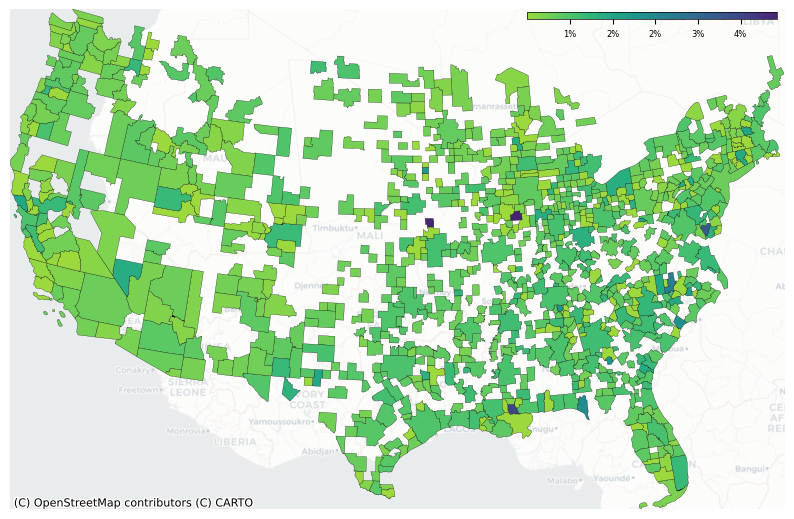

In [686]:
df = df_wad_msa_aug_25_share.copy()
metric = 'wad_18plus_share_of_population'
merged = prepare_geo_map_data(df, metric)

# Create the map with NO whitespace
fig = plot_geo_map_matplotlib(
    df=merged, 
    metric="wad_18plus_share_of_population", 
    title="Active Dx Share (%) of 18+ Population",
    figsize=(10, 5),  # Exact size you want
    legend_position="top_right",
    colormap="viridis_r", 
    colormap_start=0.15, 
    colormap_end=0.9
)

# Display it
fig.show()

# Or save it with no whitespace
fig.savefig('map.png', dpi=150, bbox_inches='tight', pad_inches=0)

### (3) Lifetime New Dx

In [687]:
df_new_dx_msa = df_new_dx.merge(df_mapping[['submarket_id','msa','cbsa']], left_on='submarket_id', right_on='submarket_id', how='left')
df_new_dx_msa['msa_mapped'] = np.where(df_new_dx_msa['msa'].isna(), 'N', 'Y')

df_new_dx_msa = df_new_dx_msa.groupby(['first_dash_month','cbsa','msa','msa_mapped']).agg(
    {'new_dx_18_to_19': 'sum'
     , 'new_dx_18_to_24': 'sum'
     , 'new_dx_25_to_44': 'sum'
     , 'new_dx_45_to_64': 'sum'
     , 'new_dx_65_above': 'sum'
     , 'new_dx_18plus': 'sum'
     , 'new_dx_18_to_19_cumsum': 'sum'
     , 'new_dx_18_to_24_cumsum': 'sum'
     , 'new_dx_25_to_44_cumsum': 'sum'
     , 'new_dx_45_to_64_cumsum': 'sum'
     , 'new_dx_65_above_cumsum': 'sum'
     , 'new_dx_18plus_cumsum': 'sum'
     , 'submarket_id': 'count'
    }
    ).reset_index()

df_new_dx_msa = df_new_dx_msa.merge(df_us_pop, left_on='cbsa', right_on='cbsa', how='left')
df_new_dx_msa['population_mapped'] = np.where(df_new_dx_msa['name'].isna(), 'N', 'Y')

In [688]:
df_new_dx_msa_aug_25 = df_new_dx_msa[df_new_dx_msa['first_dash_month'] == '2025-08-01']
df_new_dx_msa_aug_25 = df_new_dx_msa_aug_25[df_new_dx_msa_aug_25['population_mapped'] == 'Y'].reset_index(drop=True) # 3 MSA not mapped, 4k apps monthly. 

# calculate share of population
df_new_dx_msa_aug_25['lifetime_new_dx_18plus_share_of_population'] = (df_new_dx_msa_aug_25['new_dx_18plus_cumsum'] / df_new_dx_msa_aug_25['age18plus_tot']).clip(upper=1)
df_new_dx_msa_aug_25['lifetime_new_dx_18to24_share_of_population'] = (df_new_dx_msa_aug_25['new_dx_18_to_24_cumsum'] / df_new_dx_msa_aug_25['age1824_tot']).clip(upper=1)

# keep relevant columns only
df_new_dx_msa_aug_25_share = df_new_dx_msa_aug_25[['cbsa', 'msa', 'new_dx_18plus', 'new_dx_18plus_cumsum', 'age18plus_tot', 'new_dx_18_to_24', 'new_dx_18_to_24_cumsum', 'age1824_tot', 'lifetime_new_dx_18plus_share_of_population', 'lifetime_new_dx_18to24_share_of_population']]
df_new_dx_msa_aug_25_share.sort_values(by='lifetime_new_dx_18to24_share_of_population', ascending=False).head(10)

,cbsa,msa,new_dx_18plus,new_dx_18plus_cumsum,age18plus_tot,new_dx_18_to_24,new_dx_18_to_24_cumsum,age1824_tot,lifetime_new_dx_18plus_share_of_population,lifetime_new_dx_18to24_share_of_population
662,43640,"Slidell-Mandeville-Covington, LA",1557,99777.0,213503.0,568,25103.0,21724.0,0.467333,1.000000
669,43980,"Spencer, IA",35,2192.0,12817.0,19,850.0,1246.0,0.171023,0.682183
83,14010,"Bloomington, IL",904,51456.0,136470.0,394,16882.0,29513.0,0.377050,0.572019
441,32340,"Maryville, MO",99,6476.0,17005.0,47,2150.0,4751.0,0.380829,0.452536
651,43180,"Shelbyville, TN",160,6297.0,40661.0,54,1879.0,4928.0,0.154866,0.381291
207,20500,"Durham-Chapel Hill, NC",1602,101289.0,501906.0,553,27730.0,73582.0,0.201809,0.376858
436,32060,"Marion-Herrin, IL",43,4904.0,53310.0,12,1733.0,4700.0,0.091990,0.368723
429,31700,"Manchester-Nashua, NH",602,37352.0,348313.0,229,12271.0,34700.0,0.107237,0.353631
496,34820,"Myrtle Beach-Conway-North Myrtle Beach, SC",902,40854.0,345706.0,322,11500.0,32799.0,0.118176,0.350620
713,46460,"Union City, TN",38,2009.0,23711.0,11,807.0,2305.0,0.084729,0.350108


/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/3821216280.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/2011657479.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



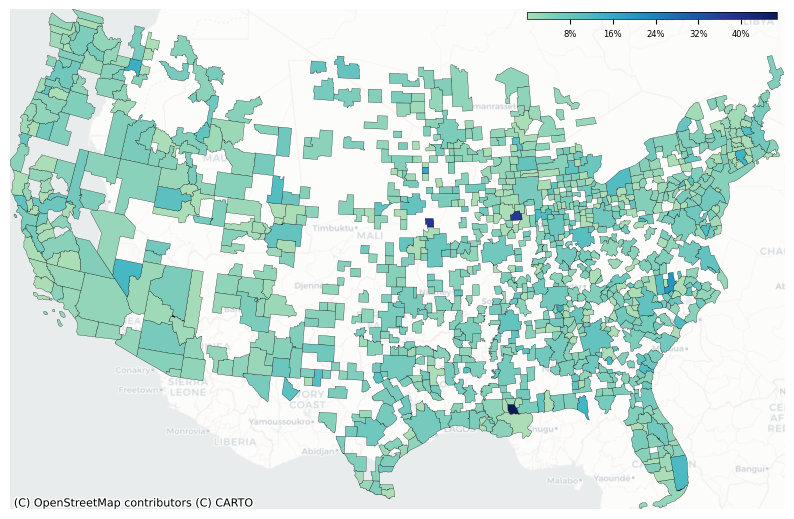

In [689]:
df = df_new_dx_msa_aug_25_share.copy()
metric = 'lifetime_new_dx_18plus_share_of_population'

merged = prepare_geo_map_data(df, metric)

fig = plot_geo_map_matplotlib(
    df=merged, 
    metric="lifetime_new_dx_18plus_share_of_population", 
    title="Lifetime New Dx Share (%) of 18+ Population",
    figsize=(10, 5),
    legend_position="top_right",
    colormap="YlGnBu", 
    colormap_start=0.3, 
    colormap_end=1
)

# Display it
fig.show()

# Or save it with no whitespace
fig.savefig('map.png', dpi=150, bbox_inches='tight', pad_inches=0)

### (4) Lifetime Applicants a share of State Population

In [690]:
df_state_popu_raw = pd.read_csv('us_population_by_state.csv')
df_state_popu_raw.columns = df_state_popu_raw.columns.str.lower()

df_state_popu = df_state_popu_raw[(df_state_popu_raw['name'] != 'United States') & (df_state_popu_raw['age'] >= 18)]
df_state_popu = df_state_popu.groupby('name').agg({'popest2024_civ': 'sum'}).reset_index()

df_state_popu_18_19 = df_state_popu_raw[(df_state_popu_raw['name'] != 'United States') & (df_state_popu_raw['age'] >= 18) & (df_state_popu_raw['age'] <= 19)]
df_state_popu_18_19 = df_state_popu_18_19.groupby('name').agg({'popest2024_civ': 'sum'}).reset_index()

df_state_popu_18_24 = df_state_popu_raw[(df_state_popu_raw['name'] != 'United States') & (df_state_popu_raw['age'] >= 18) & (df_state_popu_raw['age'] <= 24)]
df_state_popu_18_24 = df_state_popu_18_24.groupby('name').agg({'popest2024_civ': 'sum'}).reset_index()

df_state_popu = df_state_popu.merge(df_state_popu_18_24, left_on='name', right_on='name', how='left',suffixes=('_18plus', '_18_24'))
df_state_popu = df_state_popu.merge(df_state_popu_18_19, left_on='name', right_on='name', how='left')
df_state_popu.rename(columns={'popest2024_civ': 'popest2024_civ_18_19'}, inplace=True)
df_state_popu

,name,popest2024_civ_18plus,popest2024_civ_18_24,popest2024_civ_18_19
0,Alabama,18314398,969420,283504
1,Alaska,2524280,118004,32102
2,Arizona,27084048,1443334,409474
3,Arkansas,10934854,575780,162410
4,California,140353880,7188382,2113490
5,Colorado,21265554,1078712,309082
6,Connecticut,13224746,691336,205316
7,Delaware,3766712,177430,55118
8,District of Columbia,2536802,138996,41332
9,Florida,84244036,3765652,1067540


In [691]:
# State name → abbreviation dictionary
state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [692]:
df_state_popu['state_abbr'] = df_state_popu['name'].map(state_abbrev)

In [693]:
df_state_popu

,name,popest2024_civ_18plus,popest2024_civ_18_24,popest2024_civ_18_19,state_abbr
0,Alabama,18314398,969420,283504,AL
1,Alaska,2524280,118004,32102,AK
2,Arizona,27084048,1443334,409474,AZ
3,Arkansas,10934854,575780,162410,AR
4,California,140353880,7188382,2113490,CA
5,Colorado,21265554,1078712,309082,CO
6,Connecticut,13224746,691336,205316,CT
7,Delaware,3766712,177430,55118,DE
8,District of Columbia,2536802,138996,41332,DC
9,Florida,84244036,3765652,1067540,FL


In [694]:
df_apps_by_state = df_apps.merge(df_mapping[['submarket_id','submarket_name','state_name','city_state']], left_on='submarket_id', right_on='submarket_id', how='left')
df_apps_by_state = df_apps_by_state.groupby(['state_name','applied_month']).agg(
    {'apps_18plus': 'sum'
    , 'apps_18_to_19': 'sum'
    , 'apps_18_to_24': 'sum'
    , 'apps_18plus_cumsum': 'sum'
    , 'apps_18_to_19_cumsum': 'sum'
    , 'apps_18_to_24_cumsum': 'sum'}
    ).reset_index()
df_apps_by_state = df_apps_by_state.merge(df_state_popu, left_on='state_name', right_on='state_abbr', how='left')
# df_apps_by_state_aug[~df_apps_by_state_aug['city_state'].isna()][['apps_18plus_cumsum']].sum()
df_apps_by_state['share_of_population'] = df_apps_by_state['apps_18plus_cumsum'] / df_apps_by_state['popest2024_civ_18plus']
df_apps_by_state['share_of_population_18_24'] = df_apps_by_state['apps_18_to_24_cumsum'] / df_apps_by_state['popest2024_civ_18_24']
df_apps_by_state['share_of_population_18_19'] = df_apps_by_state['apps_18_to_19_cumsum'] / df_apps_by_state['popest2024_civ_18_19']

df_apps_by_state_aug = df_apps_by_state[df_apps_by_state['applied_month'] == '2025-08-01']
df_apps_by_state_aug.head()
# df_mapping

,state_name,applied_month,apps_18plus,apps_18_to_19,apps_18_to_24,apps_18plus_cumsum,apps_18_to_19_cumsum,apps_18_to_24_cumsum,name,popest2024_civ_18plus,popest2024_civ_18_24,popest2024_civ_18_19,state_abbr,share_of_population,share_of_population_18_24,share_of_population_18_19
79,AK,2025-08-01,870,91,203,77514.0,1534.0,11738.0,Alaska,2524280.0,118004.0,32102.0,AK,0.030707,0.099471,0.047785
159,AL,2025-08-01,6968,550,1208,527790.0,10556.0,81050.0,Alabama,18314398.0,969420.0,283504.0,AL,0.028818,0.083607,0.037234
239,AR,2025-08-01,3926,393,890,281958.0,6853.0,46184.0,Arkansas,10934854.0,575780.0,162410.0,AR,0.025785,0.080211,0.042196
319,AZ,2025-08-01,11118,437,1732,814784.0,10055.0,121620.0,Arizona,27084048.0,1443334.0,409474.0,AZ,0.030084,0.084263,0.024556
399,CA,2025-08-01,43016,28,125,4734594.0,3972.0,264572.0,California,140353880.0,7188382.0,2113490.0,CA,0.033733,0.036806,0.001879


In [695]:
import geopandas as gpd
import pandas as pd

# Load shapefile
states = gpd.read_file("tl_2024_us_state/tl_2024_us_state.shp")

# Project + simplify (optional, for performance)
states = states.to_crs(4326)   # WGS84
states = states.to_crs(5070)   # US Albers Equal Area
states["geometry"] = states["geometry"].simplify(tolerance=1000, preserve_topology=True)

# Exclude non-mainland states and territories
exclude = ["AK", "HI", "PR", "VI", "GU", "MP", "AS", "DC"]
states = states[~states["STUSPS"].isin(exclude)]

# Merge with your data
merged = states.merge(df_apps_by_state_aug, left_on="STUSPS", right_on="state_abbr", how="left")

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/3821216280.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/633707532.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



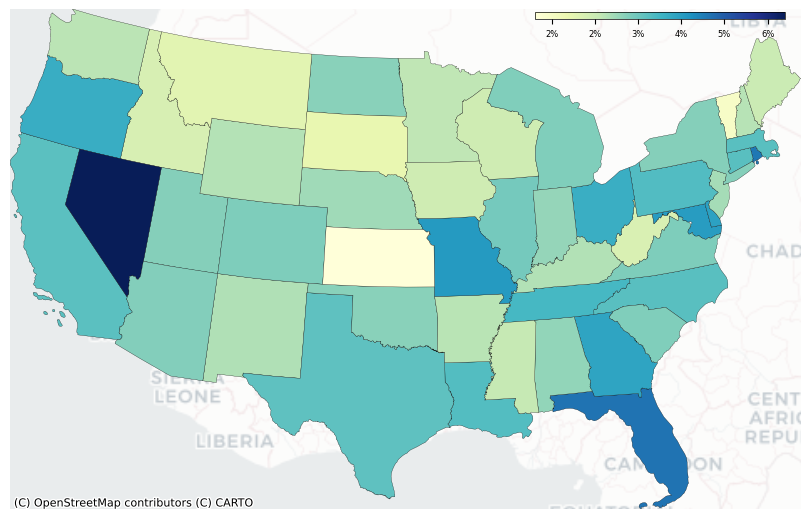

In [696]:
metric = 'share_of_population'


fig = plot_geo_map_matplotlib(
    df=merged, 
    metric=metric, 
    title="Lifetime New Dx Share (%) of 18+ Population",
    figsize=(10, 5),
    legend_position="top_right",
    colormap="YlGnBu", 
    colormap_start=0, 
    colormap_end=1
)

# Display it
fig.show()

# Or save it with no whitespace
fig.savefig('map.png', dpi=150, bbox_inches='tight', pad_inches=0)

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/3821216280.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/1219247817.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



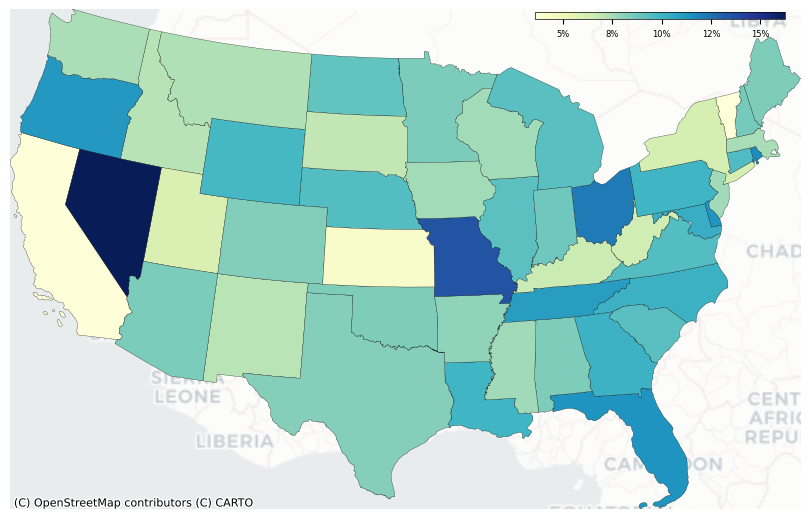

In [697]:
metric = 'share_of_population_18_24'
# share_of_population_18_19

fig = plot_geo_map_matplotlib(
    df=merged, 
    metric=metric, 
    title="Lifetime New Dx Share (%) of 18+ Population",
    figsize=(10, 5),
    legend_position="top_right",
    colormap="YlGnBu", 
    colormap_start=0, 
    colormap_end=1
)

# Display it
fig.show()

# Or save it with no whitespace
fig.savefig('map.png', dpi=150, bbox_inches='tight', pad_inches=0)

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/3821216280.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/4199766917.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



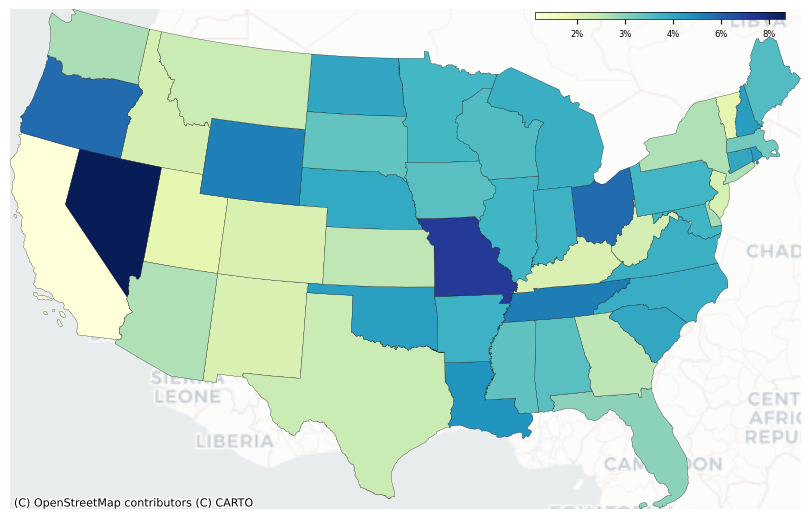

In [698]:
metric = 'share_of_population_18_19'


fig = plot_geo_map_matplotlib(
    df=merged, 
    metric="share_of_population_18_19", 
    title="Lifetime New Dx Share (%) of 18+ Population",
    figsize=(10, 5),
    legend_position="top_right",
    colormap="YlGnBu", 
    colormap_start=0, 
    colormap_end=1
)

# Display it
fig.show()

# Or save it with no whitespace
fig.savefig('map.png', dpi=150, bbox_inches='tight', pad_inches=0)

## 2. Market Saturation - Top State or MSAs

In [699]:
df_apps_by_state_aug.sort_values(by='share_of_population_18_19', ascending=False).head(10)

,state_name,applied_month,apps_18plus,apps_18_to_19,apps_18_to_24,apps_18plus_cumsum,apps_18_to_19_cumsum,apps_18_to_24_cumsum,name,popest2024_civ_18plus,popest2024_civ_18_24,popest2024_civ_18_19,state_abbr,share_of_population,share_of_population_18_24,share_of_population_18_19
2639,NV,2025-08-01,9284,607,1641,690163.0,11468.0,84177.0,Nevada,11646218.0,517670.0,143090.0,NV,0.059261,0.162607,0.080145
1919,MO,2025-08-01,11005,1062,2302,900710.0,21625.0,152266.0,Missouri,22176306.0,1130128.0,313274.0,MO,0.040616,0.134733,0.069029
2799,OH,2025-08-01,17791,1676,3620,1579158.0,34831.0,258718.0,Ohio,42358764.0,2114456.0,599618.0,OH,0.037281,0.122357,0.058089
2959,OR,2025-08-01,7317,619,1343,577644.0,11803.0,81862.0,Oregon,15431258.0,732776.0,203278.0,OR,0.037433,0.111715,0.058063
3436,TN,2025-08-01,11403,903,2152,916844.0,19131.0,140797.0,Tennessee,25665026.0,1279350.0,350968.0,TN,0.035723,0.110054,0.054509
4076,WY,2025-08-01,730,98,180,54391.0,1676.0,10532.0,Wyoming,2085076.0,107442.0,31048.0,WY,0.026086,0.098025,0.053981
1439,LA,2025-08-01,8140,665,1603,556614.0,11740.0,83020.0,Louisiana,16199796.0,835566.0,235996.0,LA,0.034359,0.099358,0.049747
79,AK,2025-08-01,870,91,203,77514.0,1534.0,11738.0,Alaska,2524280.0,118004.0,32102.0,AK,0.030707,0.099471,0.047785
3196,RI,2025-08-01,2239,176,419,179877.0,3312.0,25797.0,Rhode Island,4023950.0,220918.0,69314.0,RI,0.044702,0.116772,0.047783
2399,NH,2025-08-01,1328,145,270,133435.0,3257.0,20499.0,New Hampshire,5135312.0,239450.0,68996.0,NH,0.025984,0.085609,0.047206


In [705]:
# top_120_MSAs_population = df_wad_msa_aug_25_share.sort_values(by='age18plus_tot', ascending=False).head(120)
# top_120_MSAs_population.sort_values(by='wad_18to24_share_of_population', ascending=False).head(10)

# top_120_MSAs_population = df_new_dx_msa_aug_25_share.sort_values(by='age18plus_tot', ascending=False).head(100)
# top_120_MSAs_population.sort_values(by='lifetime_new_dx_18plus_share_of_population', ascending=False).head(20)

# old_list = ['San Jose-Sunnyvale-Santa Clara, CA', 'Virginia Beach-Chesapeake-Norfolk, VA-NC', 'San Antonio-New Braunfels, TX']
# df_new_dx_msa_aug_25_share[df_new_dx_msa_aug_25_share['msa'].isin(old_list)]

top_MSAs_population = df_apps_msa_aug_25_share.sort_values(by='age18plus_tot', ascending=False).head(80)
top_MSAs_population.sort_values(by='lifetime_apps_18plus_share_of_population', ascending=False).head(15)

,cbsa,msa,apps_18plus,apps_18plus_cumsum,age18plus_tot,apps_18_to_24,apps_18_to_24_cumsum,age1824_tot,lifetime_apps_18plus_share_of_population,lifetime_apps_18to24_share_of_population
306,25540,"Hartford-West Hartford-East Hartford, CT",3897,353772.0,944590.0,787,51520.0,117551.0,0.374524,0.438278
457,33100,"Miami-Fort Lauderdale-West Palm Beach, FL",19173,1700190.0,5186071.0,2658,178950.0,512174.0,0.327838,0.349393
392,29820,"Las Vegas-Henderson-North Las Vegas, NV",8212,602724.0,1883643.0,1432,70370.0,193548.0,0.319978,0.363579
683,44700,"Stockton-Lodi, CA",1913,193048.0,609323.0,0,11635.0,77848.0,0.316824,0.149458
624,41620,"Salt Lake City-Murray, UT",3326,308570.0,983157.0,601,37809.0,133352.0,0.313856,0.283528
615,40900,"Sacramento-Roseville-Folsom, CA",5162,599569.0,1930302.0,9,42493.0,229267.0,0.310609,0.185343
289,24660,"Greensboro-High Point, NC",2336,193368.0,628127.0,468,29354.0,85320.0,0.307849,0.344046
148,17410,"Cleveland, OH",5139,459073.0,1731154.0,1026,78564.0,174091.0,0.265183,0.451281
143,17140,"Cincinnati, OH-KY-IN",5123,464931.0,1780634.0,1107,75508.0,214642.0,0.261104,0.351786
461,33340,"Milwaukee-Waukesha, WI",4017,294274.0,1227145.0,716,46607.0,137669.0,0.239804,0.338544


In [701]:
# df_apps_by_state_aug['apps_18plus_cumsum'].sum() / df_apps_by_state_aug['popest2024_civ_18plus'].sum()

### 3. Unemployment Rate vs Applicants (%) by State

In [702]:
df_state_ur_raw = pd.read_csv('bls_state_unemployment.csv')
df_state_ur_raw.columns = df_state_ur_raw.columns.str.lower()

df_state_ur_raw

,series_id,year,period,period_name,value,state
0,LAUST010000000000003,2025,M07,July,2.9,Alabama
1,LAUST010000000000003,2025,M06,June,3.0,Alabama
2,LAUST010000000000003,2025,M05,May,2.8,Alabama
3,LAUST010000000000003,2025,M04,April,2.7,Alabama
4,LAUST010000000000003,2025,M03,March,3.4,Alabama
...,...,...,...,...,...,...
3412,LAUST560000000000003,2020,M05,May,8.9,Wyoming
3413,LAUST560000000000003,2020,M04,April,4.9,Wyoming
3414,LAUST560000000000003,2020,M03,March,6.0,Wyoming
3415,LAUST560000000000003,2020,M02,February,5.0,Wyoming


In [703]:
df_apps_by_state_output = df_apps_by_state[['state_abbr','name','applied_month','apps_18plus','apps_18_to_24','apps_18_to_19','apps_18plus_cumsum','apps_18_to_24_cumsum','apps_18_to_19_cumsum','popest2024_civ_18plus','popest2024_civ_18_24','popest2024_civ_18_19','share_of_population','share_of_population_18_24','share_of_population_18_19']]

df_apps_by_state_output.rename(columns={'state_abbr': 'state_abbr'
,'name': 'state_name'
,'applied_month': 'month'   
,'apps_18plus': 'apps_18plus'
,'apps_18_to_24': 'apps_18_to_24'
,'apps_18_to_19': 'apps_18_to_19'
,'apps_18plus_cumsum': 'apps_18plus_cumsum'
,'apps_18_to_24_cumsum': 'apps_18_to_24_cumsum'
,'apps_18_to_19_cumsum': 'apps_18_to_19_cumsum'
,'popest2024_civ_18plus': 'age_18plus_pop'
,'popest2024_civ_18_24': 'age_18_24_pop'
,'popest2024_civ_18_19': 'age_18_19_pop'
,'share_of_population': 'apps_18plus_share_of_population'
,'share_of_population_18_24': 'apps_18_to_24_share_of_age_18_24_pop'
,'share_of_population_18_19': 'apps_18_to_19_share_of_age_18_19_pop'
}, inplace=True)

df_apps_by_state_output.to_csv('df_apps_by_state_output.csv', index=False)

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_28990/1090269957.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

